In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
full_df = train_df.append(test_df, ignore_index=True)

In [2]:
cat_columns = list()
for i in train_df.columns:
    if train_df[i].dtype == 'object':
        cat_columns.append(i)
new_dfs_to_concat = list()
for i in cat_columns:
    new_df = pd.get_dummies(full_df[i], prefix=i)
    new_dfs_to_concat.append(new_df)
for i in new_dfs_to_concat:
    full_df = pd.concat([full_df, i], axis=1)
for i in cat_columns:
    full_df = full_df.drop(i,1)
full_df.head()

,ID,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,9,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
import xgboost as xgb
dtrain = xgb.DMatrix(full_df[:4209].drop(['ID', 'y', 'X232', 'X263'], axis=1), label = np.log1p(train_df['y']))

In [68]:
params = {'max_depth':2, 'eta':0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds = 100)

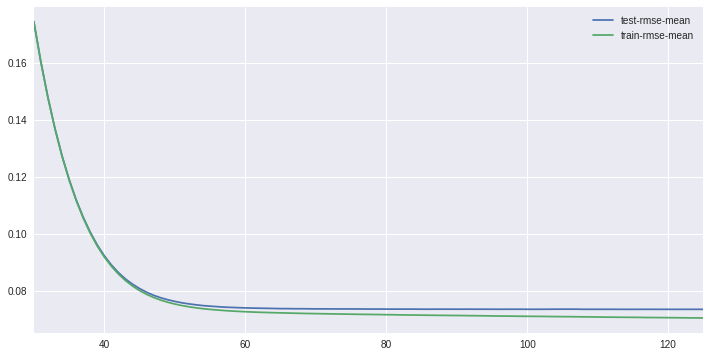

In [69]:
model.loc[30:, ['test-rmse-mean', 'train-rmse-mean']].plot()

In [70]:
model['train-rmse-mean'].min()

0.070475999999999997

In [71]:
y = np.log1p(train_df['y'])
X_train = full_df[:4209].drop(['ID', 'y'], axis=1)
xgb_model = xgb.XGBRegressor(n_estimators = 100, max_depth=2, learning_rate=0.05)
xgb_model.fit(X_train.drop(['X232', 'X263'], 1), y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

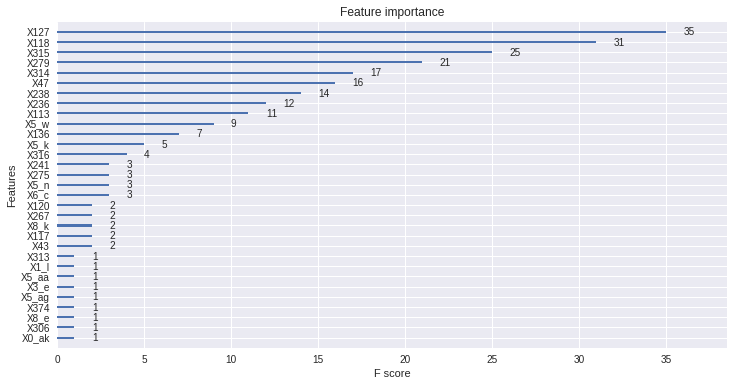

In [72]:
from xgboost import plot_importance
plot_importance(xgb_model)

In [55]:
xgb_preds = np.expm1(xgb_model.predict(X_test.drop(['X232'],1)))

In [10]:
#Doing some ridge lasso reg
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

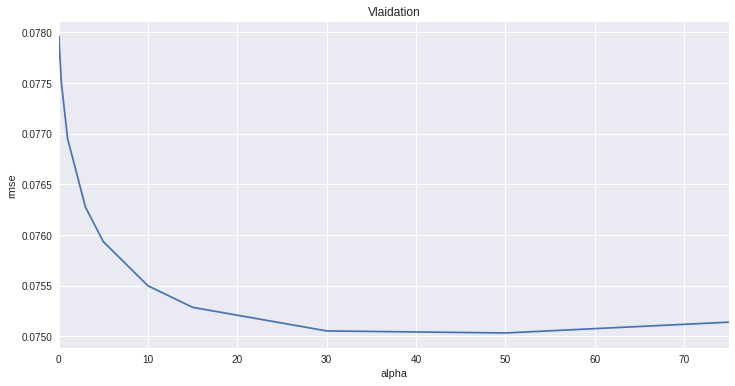

In [73]:
#Ridge reg
y = np.log1p(train_df['y'])
X_train = full_df[:4209].drop(['ID', 'y','X232', 'X263'], axis=1)
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean()
           for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='Vlaidation')
plt.xlabel('alpha')
plt.ylabel('rmse')

In [74]:
cv_ridge.min()

0.075031933240901932

In [78]:
model_lasso = LassoCV(alphas=[1,0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()

0.074725707420588358

In [80]:
coef = pd.Series(model_lasso.coef_, index=X_train.columns)

In [81]:
print 'Lasso picked '+str(sum(coef != 0)) +' variables and got rid of '+str(sum(coef==0))

Lasso picked 55 variables and got rid of 522


In [82]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

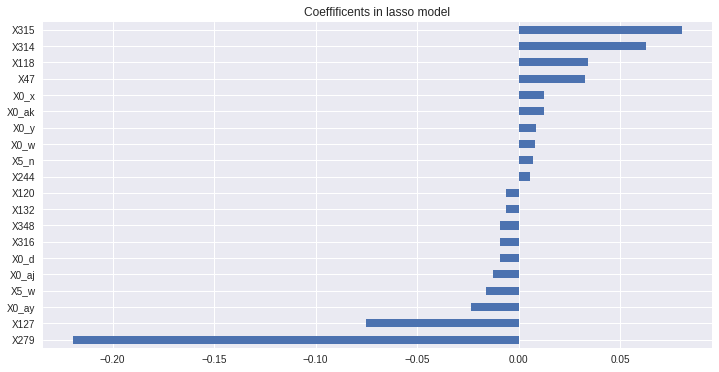

In [83]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
imp_coef.plot(kind='barh')
plt.title('Coeffificents in lasso model')

In [62]:
X_test = full_df[4209:].drop(['ID', 'y', 'X232'], axis=1)
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [63]:
new_sols = pd.DataFrame({'ID': test_df['ID'], 'y': (lasso_preds*.7)+(xgb_preds*.3)})
new_sols.head()

,ID,y
0,1,78.679103
1,2,93.469187
2,3,78.481417
3,4,78.138854
4,5,109.992043


In [66]:
new_sols.to_csv('all_feat_no_x232.csv', index=False)

In [51]:
len(train_df.loc[train_df['X127'] ==1])

2084